In [1]:
from lofarantpos.db import LofarAntennaDatabase
import lofarantpos.geo as lofargeo
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import ITRS, EarthLocation, GCRS, SkyCoord, AltAz
import numpy as np
from numpy.linalg import norm
from typing import Union

In [2]:
db = LofarAntennaDatabase()

## Test / fiddle around

In [3]:
t0 = Time("2019-01-01T01:00")
stationname = "LV614LBA"

In [4]:
def station_to_itrs(station_name):
    """Returns an astropy ITRS coordinate for a given station (e.g. 'CS001LBA')"""
    x,y,z = db.phase_centres[station_name]
    return ITRS(x=x*u.m, y=y*u.m, z=z*u.m)

In [27]:
def station_to_earthlocation(station_name):
    """Returns an astropy EarthLocation for a given station (e.g. 'CS001LBA')"""
    x,y,z = db.phase_centres[station_name]
    return EarthLocation(x=x*u.m, y=y*u.m, z=z*u.m)

We will test at zenith:

In [6]:
test_coord_skycoord = AltAz(location=station_to_earthlocation(stationname),
                            alt=89.0*u.deg, az=0*u.deg,
                            obstime=t0).transform_to(GCRS)

In [7]:
test_coord_gcrs = test_coord_skycoord.cartesian.get_xyz().value

Let's make a matrix to go from sky (GCRS) to ITRS:

In [8]:
def gcrs_to_itrs(t):
    return SkyCoord(x=np.array([1,0,0]),
                    y=np.array([0,1,0]),
                    z=np.array([0,0,1]),
                    representation_type='cartesian'
                   ).transform_to(ITRS(obstime=t)).cartesian.get_xyz().value

Test that this matrix does the same thing as an astropy transformation:

In [9]:
m31_skycoord = SkyCoord.from_name("M31")

In [11]:
m31_gcrs = m31_skycoord.cartesian.get_xyz().value

In [12]:
gcrs_to_itrs(t0).dot(m31_gcrs)

array([-0.18731299, -0.72661166,  0.66092166])

In [13]:
m31_skycoord.transform_to(ITRS(obstime=t0))

<SkyCoord (ITRS: obstime=2019-01-01T01:00:00.000): (x, y, z) [dimensionless]
    (-0.18731371, -0.72665471, 0.66097391)>

Yay.

To test whether we computed zenith, let's test whether the ITRS-vector of zenith corresponds to the ITRS-vector that points towards the station phase center.

In [14]:
station_itrs = station_to_itrs(stationname).cartesian.get_xyz().value
station_itrs /= norm(station_itrs)

In [15]:
np.rad2deg(np.arccos((gcrs_to_itrs(t0)@test_coord_gcrs)@station_itrs))

1.0423906461441619

Ok, somehow there is an error of about one degree. That's probably because the station plane is not exactly tangent to a spherical earth. Let's ignore for now.

Define the dipoles, as unit vectors in the PQR system, and convert them to ETRS.

In [16]:
a = np.sqrt(.5)
dipoles_pqr = np.array([[ a,  a, 0],
                        [ a, -a, 0],
                        [-a, -a, 0],
                        [-a,  a, 0]]).T

Note that we assume here that ITRS = ETRS, which is true to the meter level. (We could use Michiel's `etrsitrs` package here, but I think we've already got enough coordinate frames.)

So, now we have three coordinate frames:
 * GCRS (sky)
 * ITRS (Earth)
 * pqr (station)
 
We have two matrices to convert between these:
 * `pqr_to_etrs`
 * `gcrs_to_itrs`

To convert the other way around, these matrices need to be inverted, which is the same as transposing them because they are orthonormal.

In [17]:
db.pqr_to_etrs[stationname]@(db.pqr_to_etrs[stationname].T)

array([[ 1.00000001e+00, -1.23667471e-09,  4.90946427e-09],
       [-1.23667471e-09,  9.99999999e-01, -3.42687348e-09],
       [ 4.90946427e-09, -3.42687348e-09,  9.99999996e-01]])

Project the dipoles to the plane orthogonal to the test_coord. Do this in ITRS frame.

In [20]:
test_coord_itrs = gcrs_to_itrs(t0)@test_coord_gcrs

In [21]:
dipoles_itrs = db.pqr_to_etrs[stationname]@dipoles_pqr

In [22]:
dipoles_projected_itrs = dipoles_itrs - \
                         test_coord_itrs.dot(dipoles_itrs) * test_coord_itrs[:, np.newaxis]

Check that the projected dipoles are indeed orthogonal to the test coordinate:

In [23]:
dipoles_projected_itrs.T@test_coord_itrs

array([-8.09485468e-07,  1.26055095e-06,  8.09485468e-07, -1.26055095e-06])

Yay.

In [24]:
dipoles_projected_gcrs = (gcrs_to_itrs(t0).T)@dipoles_projected_itrs

These are the dipoles projected to GCRS. All we need to do now is plot them on the plane orthogonal to the vector `test_coord_gcrs`.
Unfortunately I don't know how to do this properly. Idea for now: rotate along the *z*-axis to set RA to zero, then rotate along the `y`-axis to set DEC to zero. Then the vectors should point straight up.

In [25]:
def rot_ra(phi):
    """Rotates back along the z-axis with an angle phi"""
    return  np.array([[np.cos(-phi), - np.sin(-phi), 0],
                      [np.sin(-phi),   np.cos(-phi), 0],
                      [0, 0, 1]])

Let's check this matrix by rotating `test_coord` back to ra=0:

In [26]:
test_coord_gcrs_rotra = rot_ra(test_coord_skycoord.ra)@test_coord_gcrs

In [27]:
test_coord_skycoord_rotra = SkyCoord(x=test_coord_gcrs_rotra[0],
                                     y=test_coord_gcrs_rotra[1],
                                     z=test_coord_gcrs_rotra[2],
                                     representation_type='cartesian',frame=GCRS).transform_to(GCRS)

In [28]:
test_coord_skycoord.ra.degree

136.89845023878425

In [29]:
test_coord_skycoord_rotra.ra.degree

359.9999999999938

Yay. Check that the declination does not change:

In [30]:
test_coord_skycoord.dec.degree

58.63401021546225

In [31]:
test_coord_skycoord_rotra.dec.degree

58.6340102154778

Yay.

Now rotate the declination.

In [32]:
def rot_dec(theta):
    """Rotates back along the y-axis with an angle theta"""
    return  np.array([[np.cos(-theta), 0, - np.sin(-theta)],
                      [0,              1,                0],
                      [np.sin(-theta), 0,   np.cos(-theta)]])

Test that this works (**note** we need to rotate back the RA first):

In [33]:
test_coord_gcrs_rotdec = rot_dec(test_coord_skycoord_rotra.dec)@test_coord_gcrs_rotra

In [34]:
test_coord_skycoord_rotdec = SkyCoord(x=test_coord_gcrs_rotdec[0],
                                      y=test_coord_gcrs_rotdec[1],
                                      z=test_coord_gcrs_rotdec[2],
                                      representation_type='cartesian',frame=GCRS).transform_to(GCRS)

In [35]:
test_coord_skycoord_rotdec.dec.degree

-1.967390577389944e-11

In [36]:
test_coord_skycoord_rotra.ra.degree

359.9999999999938

In [37]:
test_coord_skycoord_rotdec.ra.degree

359.9999999999905

Yay.

Now let's introduce another coordinate system, which is the rotated system so that the viewing direction looks straight at the origin (and has the same north as GCRS, because of the order in which the rotations from GCRS are done). Let's call this system `harry`.

In [38]:
def gcrs_to_harry(pointing_skycoord: SkyCoord):
    """Rotate back so that at coord_skycoord is at ra=0, dec=0"""
    return rot_dec(pointing_skycoord.dec)@rot_ra(pointing_skycoord.ra)

In [39]:
gcrs_to_harry(test_coord_skycoord)@test_coord_gcrs

array([ 1.00000000e+00,  5.55111512e-17, -5.55111512e-17])

In [40]:
gcrs_to_harry(m31_skycoord)@m31_gcrs

array([1., 0., 0.])

In [42]:
dipoles_projected_gcrs

array([[-0.24281079, -0.89241702,  0.24281079,  0.89241702],
       [-0.92905429,  0.10127823,  0.92905429, -0.10127823],
       [ 0.27890391, -0.43938692, -0.27890391,  0.43938692]])

In [44]:
gcrs_to_harry(test_coord_skycoord)@dipoles_projected_gcrs

array([[-8.09485468e-07,  1.26055095e-06,  8.09485468e-07,
        -1.26055095e-06],
       [ 8.44254267e-01,  5.35835098e-01, -8.44254267e-01,
        -5.35835098e-01],
       [ 5.35836806e-01, -8.44160543e-01, -5.35836806e-01,
         8.44160543e-01]])

Ok, so we didn't need to project the dipoles, since in the `harry` coordinate frame, projection corresponds to setting the first coordinate to zero.

In [48]:
dipoles_gcrs = (gcrs_to_itrs(t0).T)@db.pqr_to_etrs[stationname]@dipoles_pqr

In [49]:
gcrs_to_harry(test_coord_skycoord)@dipoles_gcrs

array([[ 0.00937531, -0.01459946, -0.00937531,  0.01459946],
       [ 0.84425495,  0.53583404, -0.84425495, -0.53583404],
       [ 0.53583606, -0.84415938, -0.53583606,  0.84415938]])

In [51]:
dipoles_harry = gcrs_to_harry(test_coord_skycoord)@dipoles_gcrs

Ok, let's put all of this in a function:

## Real code

In [3]:
def station_to_earthlocation(station_name):
    """Returns an astropy EarthLocation for a given station (e.g. 'CS001LBA')"""
    x,y,z = db.phase_centres[station_name]
    return EarthLocation(x=x*u.m, y=y*u.m, z=z*u.m)

In [4]:
def gcrs_to_itrs(t):
    return SkyCoord(x=np.array([1,0,0]),
                    y=np.array([0,1,0]),
                    z=np.array([0,0,1]),
                    representation_type='cartesian'
                   ).transform_to(ITRS(obstime=t)).cartesian.get_xyz().value

In [5]:
def rot_ra(phi):
    """Rotates back along the z-axis with an angle phi"""
    return  np.array([[np.cos(-phi), - np.sin(-phi), 0],
                      [np.sin(-phi),   np.cos(-phi), 0],
                      [0, 0, 1]])



In [6]:
def rot_dec(theta):
    """Rotates back along the y-axis with an angle theta"""
    return  np.array([[np.cos(-theta), 0, - np.sin(-theta)],
                      [0,              1,                0],
                      [np.sin(-theta), 0,   np.cos(-theta)]])

In [7]:
def gcrs_to_harry(pointing_skycoord: SkyCoord):
    """Rotate back so that at coord_skycoord is at ra=0, dec=0"""
    return rot_dec(pointing_skycoord.dec)@rot_ra(pointing_skycoord.ra)

In [8]:
def get_dipoles_harry(pointing_skycoord, time, stationname):
    a = np.sqrt(.5)
    dipoles_pqr = np.array([[ a,  a, 0],
                            [ a, -a, 0],
                            [-a, -a, 0],
                            [-a,  a, 0]]).T
    dipoles_gcrs = (gcrs_to_itrs(time).T) @ db.pqr_to_etrs[stationname] @ dipoles_pqr
    dipoles_harry = gcrs_to_harry(pointing_skycoord) @ dipoles_gcrs
    return dipoles_harry

In [9]:
dipoles_harry = get_dipoles_harry(SkyCoord.from_name("M31"), Time.now(), "IE613LBA")

In [10]:
def plot_dipoles_harry(pointing_str: str, timedelta: float, stationname: str):
    """Plot projected dipoles"""
    fig, ax = plt.subplots(1)
    
    t0 = Time("2019-01-01T01:00")
    
    if pointing_str == "zenith":
        pointing = AltAz(location=station_to_earthlocation(stationname),
                         alt=89.0*u.deg, az=0*u.deg,
                         obstime=t0).transform_to(GCRS)
    else:
        pointing = SkyCoord.from_name(pointing_str)

    time = t0 + timedelta * u.day
    
    dipoles_harry = get_dipoles_harry(pointing,
                                      time,
                                      stationname)
    
    x, y = dipoles_harry[1:3]
    ax.grid()
    ax.arrow(x[2], y[2], x[0] - x[2], y[0] - y[2], head_width=0.1, color='r',
             length_includes_head=True)
    ax.arrow(x[1], y[1], x[3] - x[1], y[3] - y[1], head_width=0.1, color='b',
             length_includes_head=True)
    ax.set_aspect(1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.tick_params(axis="x", bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis="y", left=False, right=False, labelleft=False)
    ax.set_xlabel(r"$\Delta  \alpha$", fontsize=16)
    ax.set_ylabel(r"$\Delta  \delta$", fontsize=16)
    ax.set_title(f"Dipoles of {stationname} as seen from \n{pointing_str} at {time.iso[:16]}")
    _ = ax.plot(0, 0, 'kx');
    return fig

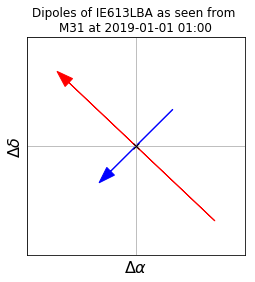

In [11]:
plot_dipoles_harry("M31", 0, "IE613LBA");

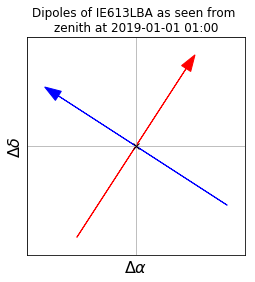

In [12]:
plot_dipoles_harry("zenith", 0, "IE613LBA");

Try from the superterp (where up should be North):

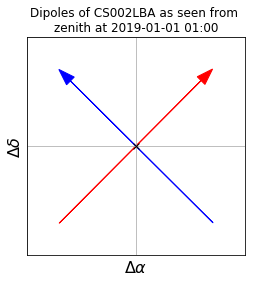

In [13]:
plot_dipoles_harry("zenith", 0, "CS002LBA");

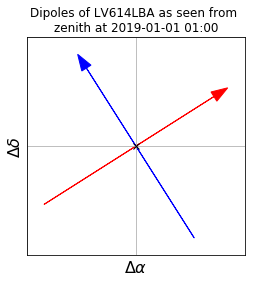

In [14]:
plot_dipoles_harry("zenith", 0, "LV614LBA");

Now make it interactive:

In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [16]:
interactive_plot = interactive(plot_dipoles_harry,
                               stationname=list(db.phase_centres.keys()),
                               timedelta=(0., 1., 0.05),
                               pointing_str=["M31", "Cas A", "zenith"])
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='pointing_str', options=('M31', 'Cas A', 'zenith'), value='M31'), F…

In [18]:
for framenum, time_delta in enumerate(np.linspace(0, 1, 120)):
    f = plot_dipoles_harry("zenith", time_delta, "CS002LBA");
    _ = f.savefig(f"frame{framenum:03d}.png");

/anaconda/envs/school19/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
